In [1]:
import numpy as np # linear algebra
import pandas as pd
import os
import tensorflow_addons as tfa
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf

print("Tensorflow version " + tf.__version__)

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, SeparableConv2D, BatchNormalization, MaxPool2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.vgg19 import VGG19

Tensorflow version 2.6.4


In [2]:
base_path = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data/fold_0"
test_path = "/kaggle/input/malariadata/Newfold" 

In [12]:
# use image generator to add more pic and do some image pre-proccessing : scaling . and divid the data into training and validation  

image_shape = [224,224]
batch_size = 32
epochs = 20
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.3) # set validation split

train_generator = train_datagen.flow_from_directory(
    base_path,
    target_size = (image_shape[0], image_shape[1]),
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    base_path, # same directory as training data
    target_size = (image_shape[0], image_shape[1]),
    batch_size = batch_size,
    class_mode='binary',
    shuffle = True,
    subset='validation') # set as validation data

test_datagenerator = ImageDataGenerator(rescale=1./255)

test = test_datagenerator.flow_from_directory(test_path,
                                                  target_size = (image_shape[0], image_shape[1]),
                                                  batch_size = batch_size,
                                                  class_mode = 'binary',
                                                  classes = ['Parasitized','Uninfected'],
                                                  shuffle = False)

Found 2469 images belonging to 2 classes.
Found 1058 images belonging to 2 classes.
Found 39 images belonging to 2 classes.


In [ ]:

# image_shape = [224, 224]
# batch_size = 64
# epochs = 30
# train_datagenerator = ImageDataGenerator(rescale=1./255)

# train = train_datagenerator.flow_from_directory(train_df,
#                                                     target_size = (image_shape[0], image_shape[1]),
#                                                     batch_size = batch_size,
#                                                     class_mode = 'binary',
#                                                     shuffle = True
#                                                    )

# validation_datagenerator = ImageDataGenerator(rescale=1./255)

# validation = validation_datagenerator.flow_from_directory(train_df,
#                                                   target_size = (image_shape[0], image_shape[1]),
#                                                   batch_size = batch_size,
#                                                   class_mode = 'binary',
#                                                   shuffle = True
#                                                  )

# test_datagenerator = ImageDataGenerator(rescale=1./255)

# test = test_datagenerator.flow_from_directory(test_path,
#                                                   target_size = (image_shape[0], image_shape[1]),
#                                                   batch_size = batch_size,
#                                                   class_mode = 'binary',
#                                                   shuffle = False)

In [4]:
train_generator.class_indices


{'all': 0, 'hem': 1}

In [5]:
test.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [6]:
# defining some fixed parameters


# instantiating the VGG19 model
vgg19 = VGG19(input_shape=(image_shape[0], image_shape[1], 3),
                  weights='imagenet', # include the pre-trained weights on ImageNet
                  include_top=False)  # to use our own input and get the desired output

# do not train the existing weights
for layer in vgg19.layers:
  layer.trainable = False

# defining input and output to the model
x = tf.keras.layers.Flatten()(vgg19.output)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs = vgg19.input, outputs = output)


80150528/80134624 [==============================] - 4s 0us/step


In [10]:
metrics = ['accuracy',
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
           tf.keras.metrics.AUC(name = "AUC")
          ]

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = metrics)

# stop model training is the validation loss does not decrease for 5 epochs
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                              patience=10,
                                              verbose=1,
                                              mode="auto",
                                              restore_best_weights=True
)

# reducing the learning rate every 5 epochs
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='leukemia10.h5', 
                                                monitor='val_loss', 
                                                verbose=1, 
                                                save_best_only=True,
                                                save_weights_only=False, 
                                                mode='min', 
                                                save_freq='epoch'
)

In [13]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_generator.samples // train_generator.batch_size,
                    epochs=epochs,
                    validation_steps=validation_generator.samples // validation_generator.batch_size,
                    callbacks=[early_stop, lr_scheduler, checkpoint],
                    verbose=2
                    )

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
77/77 - 61s - loss: 0.4954 - accuracy: 0.7801 - precision: 0.6945 - recall: 0.5632 - AUC: 0.8034 - val_loss: 0.5246 - val_accuracy: 0.7831 - val_precision: 0.7411 - val_recall: 0.4926 - val_AUC: 0.7675

Epoch 00001: val_loss improved from inf to 0.52462, saving model to leukemia10.h5
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
77/77 - 42s - loss: 0.4875 - accuracy: 0.7944 - precision: 0.7328 - recall: 0.5604 - AUC: 0.8044 - val_loss: 0.5088 - val_accuracy: 0.7775 - val_precision: 0.7418 - val_recall: 0.4675 - val_AUC: 0.7878

Epoch 00002: val_loss improved from 0.52462 to 0.50881, saving model to leukemia10.h5
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
77/77 - 42s - loss: 0.5282 - accuracy: 0.7677 - precision: 0.6579 - recall: 0.5736 - AUC: 0.7876 - val_loss: 0.6286 - val_accuracy: 0.7699 - val_precision: 0.8992 - val_recall: 0.3166 - val

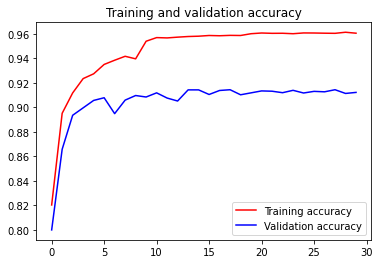

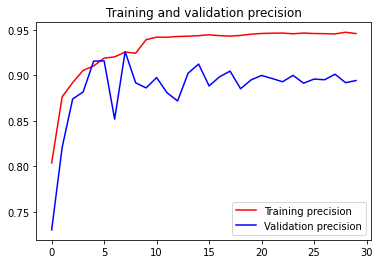

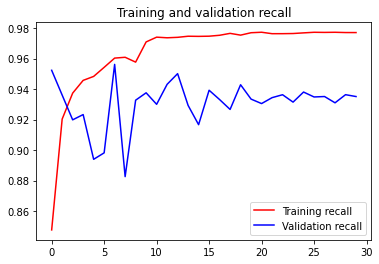

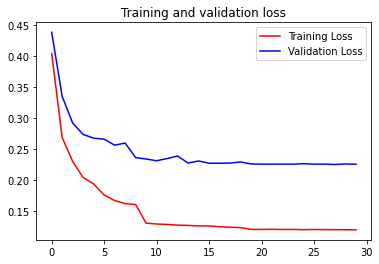

<Figure size 432x288 with 0 Axes>

In [9]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']



epochs = range(len(acc))
plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig("output11.png") #save as jpg


plt.figure()

plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.legend()
plt.savefig("output22.png") #save as jpg


plt.figure()

plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.legend()
plt.savefig("output33.png") #save as jpg


plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig("output44.png") #save as jpg


plt.figure()

plt.show()



In [22]:
import tensorflow as tf
from keras.models import load_model
# load the saved model
saved_model = tf.keras.models.load_model('/kaggle/input/malaria2/malaria5.h5')

In [ ]:
# y_pred

In [23]:
y_pred5 = saved_model.predict(test)

In [24]:
p_pred1 = y_pred5.flatten()
print(p_pred1.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

# extract the predicted class labels
y_pred1 = np.where(p_pred1 > 0.5, 1, 0)
print(y_pred1)

[0.   0.03 0.   0.01 0.33 0.   0.   0.   0.   0.   0.   0.   0.24 0.
 0.   0.   0.   0.   0.69 0.   0.   0.   0.4  0.16 0.01 0.01 0.   0.03
 0.   0.   0.98 0.77 0.93 0.97 0.99 0.94 0.98 0.98 0.96]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1]


In [25]:
set_res = set(y_pred1) 
print("The unique elements of the input list using set():\n") 
list_res = (list(set_res))
 
for item in list_res: 
    print(item) 

The unique elements of the input list using set():

0
1


In [20]:
y_pred1

array([0, 0, 0, ..., 1, 1, 1])

In [26]:
infected = []
healthy = []
for pred in y_pred1:
    if pred == 0:
        infected.append(pred)
    # if prediction is 1, append image to healthy list
    elif pred == 1:
        healthy.append(pred)

In [27]:
total_samples = len(infected) + len(healthy)
# calculate percentage of infected images
para = (len(infected) / total_samples) * 100

In [28]:
print(para)

74.35897435897436


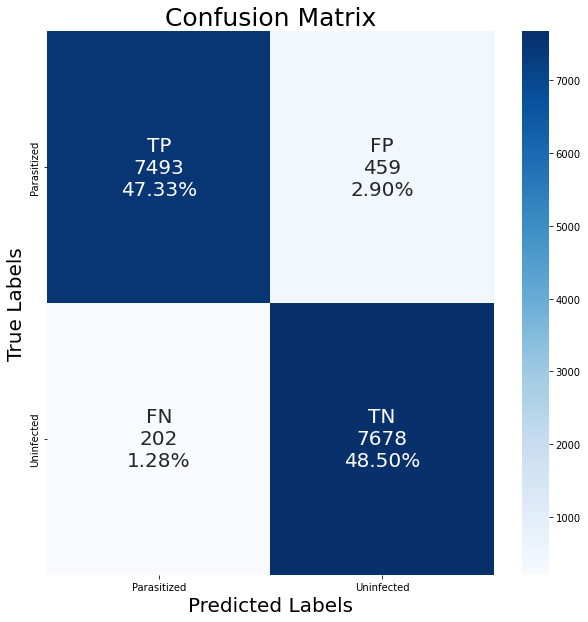

In [10]:
# Standard Imports
import os
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Visualization
import matplotlib.image as implt # Visualization
import seaborn as sns 

# For Network
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
import datetime
from sklearn.metrics import confusion_matrix

CLASSES = ['Parasitized' , 'Uninfected']
#y_pred = model.predict(test_generator).argmax(axis=-1)

conf_mat = confusion_matrix(test.classes, y_pred1)
group_names = ['TP','FP','FN','TN']
group_counts = ['{0:0.0f}'.format(value) for value in conf_mat.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in conf_mat.flatten()/np.sum(conf_mat)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, xticklabels=CLASSES, yticklabels=CLASSES, ax=ax, annot=labels, fmt='', cbar=True, annot_kws={'size': 20}, cmap='Blues')
ax.set_xlabel('Predicted Labels', fontsize=20)
ax.set_ylabel('True Labels', fontsize=20)
plt.title('Confusion Matrix', fontsize=25)
plt.savefig('Confusion Matrix.png')

In [ ]:
model_train_performace = model.evaluate(train


In [5]:
model_test_performace = saved_model.evaluate(test)

2022-12-03 08:18:30.625975: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-03 08:18:32.354231: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


495/495 [==============================] - 77s 135ms/step - loss: 0.1252 - accuracy: 0.9582 - precision: 0.9436 - recall: 0.9744


In [ ]:
# test_accuracy = model_test_performace[1]
# test_precision = model_test_performace[2]
# test_recall = model_test_performace[3]


# print(f'Test accuracy: {round(test_accuracy*100, 2)}%')
# print(f'Test precision: {round(test_precision*100, 2)}%')
# print(f'Test recall: {round(test_recall*100, 2)}%')


In [ ]:
# train_accuracy = model_train_performace[1]
# train_precision = model_train_performace[2]
# train_recall = model_train_performace[3]


# print(f'Train accuracy: {round(train_accuracy*100, 2)}%')
# print(f'Train precision: {round(train_precision*100, 2)}%')
# print(f'Train recall: {round(train_recall*100, 2)}%') 


In [ ]:
#train_F1= 2 * ((train_precision * train_recall) / (train_precision + train_recall))
#print(f'Train F1: {round(train_F1*100, 2)}%') 

In [ ]:
#test_F1= 2*((test_precision * test_precision) / (test_precision + test_precision))
#print(f'Test F1: {round(test_F1*100, 2)}%') 

In [ ]:
# MODEL_PATH ='../input/malaria2/malaria5.h5'

# saved_model = tf.keras.models.load_model(MODEL_PATH)

# y_pred5 = saved_model.predict(test)

In [ ]:
# y_pred5

In [ ]:

# p_pred1 = y_pred5.flatten()
# print(p_pred1.round(2))
#    # [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

#    # extract the predicted class labels
# y_pred1 = np.where(p_pred1 > 0.5, 1, 0)
# y_pred1

In [ ]:
# set_res = set(y_pred1) 
# print("The unique elements of the input list using set():\n") 
# list_res = (list(set_res))
 
# for item in list_res: 
#     print(item) 

In [ ]:
# def predict_input_image(img):
#   img_4d=img.reshape(-1,224,224,3)
#   prediction=saved_model.predict(img_4d)[0]

#   p_pred1 = prediction.flatten()
#   print(p_pred1.round(2))
#    # [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

#    # extract the predicted class labels
#   y_pred1 = np.where(p_pred1 > 0.5, 1, 0)
  

#   if y_pred1 == 1:
#         print("The Person is Infected With Pneumonia")
#   else:
#         print("The Person is not Infected With Pneumonia")

#   return y_pred1

In [ ]:
# import keras.preprocessing.image
# from tensorflow.keras.utils import load_img
# from tensorflow.keras.utils import img_to_array
# test_image= "../input/maaeea/single_prediction/Parasitised.png"
# test_image= load_img(test_image,target_size=(224 , 224))
# print("The following test image is of Parasitized Cell with label '1'")
# test_image

In [ ]:
# test_image= img_to_array(test_image)
# test_image = np.expand_dims(test_image, axis=0)
# print(test_image.shape)

In [ ]:

# pred = predict_input_image(test_image)
# pred